# 035. 네이버 영화평 감성 분류

- 한글 형태소 분석기 Okt 사용 전처리  

- Keras Tokenizer, pad_sequences 함수 사용

In [1]:
!pip install -q KoNLPy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 28.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import re
import time
import matplotlib.pyplot as plt

from konlpy.tag import Okt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, Dense, LSTM

# 시드 설정
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [3]:
DATA_TRAIN_PATH = tf.keras.utils.get_file("ratings_train.txt",
                        "https://raw.github.com/ironmanciti/Infran_NLP/main/data/naver_movie/ratings_train.txt")
DATA_TEST_PATH = tf.keras.utils.get_file("ratings_test.txt",
                        "https://raw.github.com/ironmanciti/Infran_NLP/main/data/naver_movie/ratings_test.txt")

4893335/4893335 [==============================] - 0s 0us/step


In [4]:
train_data = pd.read_csv(DATA_TRAIN_PATH, delimiter='\t')
print(train_data.shape)
train_data.head()

(150000, 3)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [5]:
test_data = pd.read_csv(DATA_TEST_PATH, delimiter='\t')
print(test_data.shape)
test_data.head()

(50000, 3)


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


### 훈련 시간을 감안하여 data size 축소

In [6]:
# 훈련 데이터에서 50,000개의 샘플을 무작위로 선택 (재현성을 위해 random_state=1 사용)
train_data = train_data.sample(n=50000, random_state=1)

# 테스트 데이터에서 5,000개의 샘플을 무작위로 선택 (재현성을 위해 random_state=1 사용)
test_data = test_data.sample(n=5000, random_state=1)

print(train_data.shape)
print(test_data.shape)

(50000, 3)
(5000, 3)


**null value 제거**

In [7]:
train_data.dropna(inplace=True)

test_data.dropna(inplace=True)

In [8]:
train_data.isnull().sum(), test_data.isnull().sum()

(id          0
 document    0
 label       0
 dtype: int64,
 id          0
 document    0
 label       0
 dtype: int64)

### okt.morphs()

- 텍스트를 형태소 단위로 나눈다. 옵션으로는 norm과 stem이 있다
- stem은 각 단어에서 어간을 추출하는 기능

In [9]:
okt = Okt()
test = "아버지가방에들어가신다"
okt.morphs(test, stem=True)

['아버지', '가방', '에', '들어가다']

## Text Data 전처리

**한글 문자가 아닌 것 모두 제거**

In [10]:
def preprocessing(sentence, remove_stopwords=True):
    # 불용어 리스트 정의 (현재는 빈 리스트로 설정)
    # stop_words = set(['에', '은', '는', '이', '가', '그리고', '것', '들', '수', '등', '로', '을', '를', '만', '도', '아', '의', '그', '다'])
    stop_words = []

    # 개행문자 제거
    sentence = re.sub('\\\\n', ' ', sentence)

    # 한글 외의 모든 문자 제거
    sentence = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣ ]', '', sentence)

    # 형태소 분석 및 어간 추출
    sentence = okt.morphs(sentence, stem=True)

    # 불용어 제거 옵션이 True인 경우, 불용어 리스트에 포함되지 않은 토큰만 선택
    if remove_stopwords:
        sentence = [token for token in sentence if not token in stop_words]

    # 전처리된 문장 반환
    return sentence

In [11]:
%%time

# 훈련 문장과 레이블을 저장할 리스트 초기화
train_sentences = []
train_labels = []

# 테스트 문장과 레이블을 저장할 리스트 초기화
test_sentences = []
test_labels = []

# 시작 시간 기록
start = time.time()

# 훈련 데이터 전처리
for i, (sent, label) in enumerate(zip(train_data['document'], train_data['label'])):
    # 10,000개마다 진행 상황 출력
    if i % 10000 == 0:
        print(f"Train processed = {i}")
    # 문장 전처리 수행
    sent = preprocessing(sent)
    # 전처리 후 문장이 비어있지 않으면 리스트에 추가
    if len(sent) > 0:
        train_sentences.append(sent)
        train_labels.append(label)

# 테스트 데이터 전처리
for i, (sent, label) in enumerate(zip(test_data['document'], test_data['label'])):
    # 1,000개마다 진행 상황 출력
    if i % 1000 == 0:
        print(f"Test processed = {i}")
    # 문장 전처리 수행
    sent = preprocessing(sent)
    # 전처리 후 문장이 비어있지 않으면 리스트에 추가
    if len(sent) > 0:
        test_sentences.append(sent)
        test_labels.append(label)

# 전처리에 걸린 총 시간 출력
print(time.time() - start)

Train processed = 0
Train processed = 10000
Train processed = 20000
Train processed = 30000
Train processed = 40000
Test processed = 0
Test processed = 1000
Test processed = 2000
Test processed = 3000
Test processed = 4000
214.96292304992676
CPU times: user 3min 41s, sys: 999 ms, total: 3min 42s
Wall time: 3min 34s


## train_labels, test_labels  list를 numpy array 로 변환

In [12]:
# 훈련 레이블을 numpy 배열로 변환
train_labels = np.array(train_labels)

# 테스트 레이블을 numpy 배열로 변환
test_labels = np.array(test_labels)

print(train_labels.shape)
print(test_labels.shape)

(49571,)
(4951,)


## train_sentences, test_sentences text 를 sequence 로 변환

In [13]:
# 어휘 사전의 최대 크기 설정
VOCAB_SIZE = 20000

# Tokenizer 객체 생성 (최대 단어 수 지정 및 OOV(Out-Of-Vocabulary) 토큰 설정)
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")

# 훈련 문장에 대해 토크나이저 학습 수행 (단어 인덱스 구축)
tokenizer.fit_on_texts(train_sentences)

# 훈련 문장들을 시퀀스로 변환
train_sequences = tokenizer.texts_to_sequences(train_sentences)

# 테스트 문장들을 시퀀스로 변환
test_sequences = tokenizer.texts_to_sequences(test_sentences)

# 첫 번째 시퀀스 출력
print(train_sequences[0])
print(test_sequences[0])

[90, 1370, 13, 1554, 80, 520, 8870, 14637, 29, 250, 5, 3884, 16, 430, 62, 210, 30, 1612, 14, 744, 22, 229, 6, 1123, 13, 31, 43, 12, 149, 2547, 5, 741, 12, 1554, 14638, 6007, 8871, 8872, 8, 31]
[1683, 7, 460, 1491, 106, 346, 37, 2485, 344, 760, 206, 650, 96, 270]


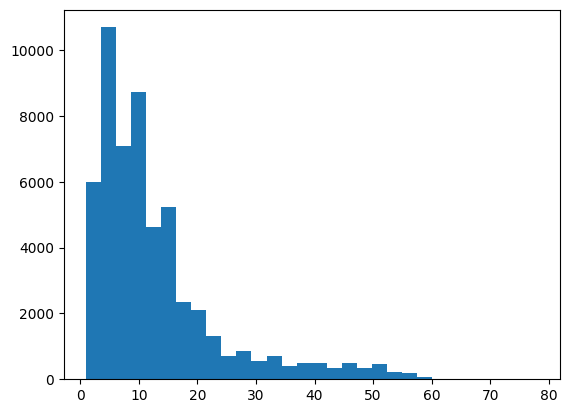

In [14]:
# 훈련 시퀀스와 테스트 시퀀스의 길이를 리스트로 변환하여 합친 후 히스토그램으로 시각화
plt.hist([len(s) for s in train_sequences] + [len(s) for s in test_sequences], bins=30);

In [15]:
max_length = 15

# 훈련 시퀀스를 패딩 처리 (최대 길이를 15로 설정, 'post' 방식으로 잘라내고 패딩)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')

# 테스트 시퀀스를 패딩 처리 (최대 길이를 15로 설정, 'post' 방식으로 잘라내고 패딩)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

print(train_padded.shape)
print(test_padded.shape)

# 첫 번째 패딩된 시퀀스 출력
print(train_padded[0])
print(test_padded[0])

(49571, 15)
(4951, 15)
[   90  1370    13  1554    80   520  8870 14637    29   250     5  3884
    16   430    62]
[1683    7  460 1491  106  346   37 2485  344  760  206  650   96  270
    0]


### sequence 를 다시 문장으로 역변환

In [16]:
# 단어 인덱스를 키로, 단어를 값으로 하는 사전 생성
reverse_word_index = dict([(v, k) for (k, v) in tokenizer.word_index.items()])

# 시퀀스를 문장으로 디코딩하는 함수
def decode_sentence(sequence):
    # 시퀀스의 각 인덱스를 단어로 변환하여 리스트로 만들고, 이를 공백으로 연결하여 문자열로 반환
    return ' '.join([reverse_word_index.get(i, '?') for i in sequence])

# 다섯 번째 패딩된 훈련 시퀀스를 디코딩하여 출력
print(decode_sentence(train_padded[4]))
print()

# 다섯 번째 훈련 문장 원본 출력
print(train_sentences[4])

우리나라 용가리 가 배다 더 자다 만들다 이렇다 류 영화 도 개봉 을 하나 보다

['우리나라', '용가리', '가', '배다', '더', '자다', '만들다', '이렇다', '류', '영화', '도', '개봉', '을', '하나', '보다']


In [17]:
model = Sequential([
    Embedding(VOCAB_SIZE+1, 64),
    Bidirectional(LSTM(64)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, max_length))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          1280064   
                                                                 
 bidirectional (Bidirection  (None, 128)               66048     
 al)                                                             
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1350273 (5.15 MB)
Trainable params: 1350273 (5.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
%%time
num_epochs = 30
history = model.fit(train_padded, train_labels, epochs=num_epochs, batch_size=128,
                    validation_data=(test_padded, test_labels), verbose=1)

Epoch 1/30
388/388 [==============================] - 32s 63ms/step - loss: 0.4514 - accuracy: 0.7789 - val_loss: 0.4066 - val_accuracy: 0.8136
Epoch 2/30
388/388 [==============================] - 8s 20ms/step - loss: 0.3307 - accuracy: 0.8576 - val_loss: 0.4024 - val_accuracy: 0.8142
Epoch 3/30
388/388 [==============================] - 5s 12ms/step - loss: 0.2736 - accuracy: 0.8832 - val_loss: 0.4372 - val_accuracy: 0.8160
Epoch 4/30
388/388 [==============================] - 4s 11ms/step - loss: 0.2226 - accuracy: 0.9044 - val_loss: 0.4650 - val_accuracy: 0.8158
Epoch 5/30
388/388 [==============================] - 5s 13ms/step - loss: 0.1853 - accuracy: 0.9191 - val_loss: 0.5350 - val_accuracy: 0.8083
Epoch 6/30
388/388 [==============================] - 4s 9ms/step - loss: 0.1591 - accuracy: 0.9313 - val_loss: 0.6591 - val_accuracy: 0.8027
Epoch 7/30
388/388 [==============================] - 4s 11ms/step - loss: 0.1369 - accuracy: 0.9417 - val_loss: 0.7045 - val_accuracy: 0.8126

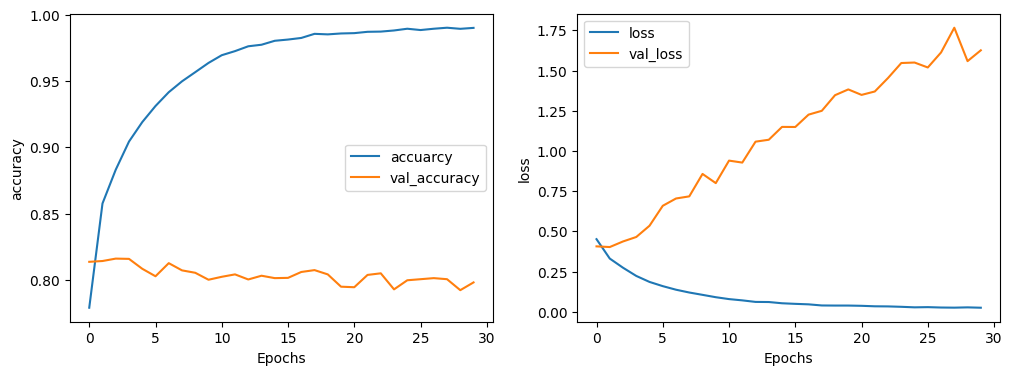

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel('Epochs')
ax1.set_ylabel('accuracy')
ax1.legend(['accuarcy', 'val_accuracy'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('Epochs')
ax2.set_ylabel('loss')
ax2.legend(['loss', 'val_loss'])
plt.show()

In [20]:
test_data.head()

,id,document,label
26247,5933705,크리스마스에 어울리는 시원한 액션. 긴장감과 박진감 넘치는 전개 엄청난 마지막부분,1
35067,5092284,또 봐도 재밌네요 ㅋ2편은 평점이거지네요;;,1
34590,4501201,완전유치뽕짝저질삼류영화..티비편이 훨씬낫다...,0
16668,8848074,이건 보는 영화가 아니다.,0
12196,178689,오랜만에 접한 수작...30대 중반 이상분들에게 추천!,1


In [30]:
sample_text = ['이 영화는 정말 짜증나서 못 보겠다']
#sample_text = ['오랜만에 접한 수작']
sample_seq = tokenizer.texts_to_sequences(sample_text)
sample_padded = pad_sequences(sample_seq, maxlen=max_length, padding='post')
sample_padded

array([[ 2,  1, 21,  1, 49,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0]],
      dtype=int32)

In [31]:
model.predict([sample_padded])

1/1 [==============================] - 0s 19ms/step


array([[0.08060081]], dtype=float32)

In [32]:
['positive' if model.predict([sample_padded]) >= 0.5 else 'negative']

1/1 [==============================] - 0s 18ms/step


['negative']

In [24]:
model.layers

## Embedding Layer 시각화

- Embedding projector https://projector.tensorflow.org/  를 이용하여 word embedding 시각화

In [25]:
# 모델의 첫 번째 레이어 (임베딩 레이어) 가져오기
e = model.layers[0]

# 임베딩 레이어의 가중치 가져오기
weights = e.get_weights()[0]

# 임베딩 가중치의 형태 출력
print(weights.shape)

(20001, 64)


### embedding layer 의 weight 를 disk 에 write. Embedding projector 사용을 위해 embedding vector file 과 단어가 들어 있는 meta data file 로 구분하여 upload.

In [26]:
# 벡터와 메타데이터를 저장할 파일 열기 (UTF-8 인코딩 사용)
out_v = open('vects.tsv', 'w', encoding='utf-8')
out_m = open('meta.tsv', 'w', encoding='utf-8')

# 단어 인덱스 1부터 999까지 반복
for i in range(1, 1000):
    # 단어 인덱스를 단어로 변환 (인덱스가 없으면 '?' 반환)
    word = tokenizer.index_word.get(i, '?')
    # 해당 단어의 임베딩 벡터 가져오기
    embeddings = weights[i]
    # 메타데이터 파일에 단어 쓰기
    out_m.write(word + '\n')
    # 벡터 파일에 임베딩 벡터 쓰기 (탭으로 구분)
    out_v.write('\t'.join([str(x) for x in embeddings]) + '\n')

# 파일 닫기
out_v.close()
out_m.close()

## Embedding 결과 확인

[Embedding Projector](https://projector.tensorflow.org) 에 접속하여 embedding 의 품질 확인

Google Colab 의 경우 local PC 로 download 받아 Embedding Projector 에 upload